# Basic Examples for the DoE Subpackage

The following example has been taken from the paper "The construction of D- and I-optimal designs for mixture experiments with linear constraints on the components" by R. Coetzer and L. M. Haines (https://www.sciencedirect.com/science/article/pii/S0169743917303106). 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

import bofire.strategies.api as strategies
from bofire.data_models.constraints.api import (
    InterpointEqualityConstraint,
    LinearEqualityConstraint,
    LinearInequalityConstraint,
    NonlinearEqualityConstraint,
    NonlinearInequalityConstraint,
)
from bofire.data_models.domain.api import Domain
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.strategies.api import DoEStrategy
from bofire.data_models.strategies.doe import DOptimalityCriterion, IOptimalityCriterion

## Linear model

Creating an experimental design that is D-optimal with respect to a linear model is done the same way as making proposals using other methods in BoFire; you 
1. create a domain
2. construct a stategy data model (here we want DoEStrategy)
3. map the strategy to its functional version, and finally 
4. ask the strategy for proposals. 
   
We will start with the simplest case: make a design based on a linear model containing main-effects (i.e., simply the inputs themselves and an intercept, without any second-order terms).

In [ ]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds=(0, 1)),
        ContinuousInput(key="x2", bounds=(0.1, 1)),
        ContinuousInput(key="x3", bounds=(0, 0.6)),
    ],
    outputs=[ContinuousOutput(key="y")],
    constraints=[
        LinearEqualityConstraint(
            features=["x1", "x2", "x3"],
            coefficients=[1, 1, 1],
            rhs=1,
        ),
        LinearInequalityConstraint(features=["x1", "x2"], coefficients=[5, 4], rhs=3.9),
        LinearInequalityConstraint(
            features=["x1", "x2"],
            coefficients=[-20, 5],
            rhs=-3,
        ),
    ],
)

data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(formula="linear"),
    ipopt_options={"disp": 0},
)
strategy = strategies.map(data_model=data_model)
candidates = strategy.ask(candidate_count=12)

Let's visualize the experiments that were chosen. We will see that such a design puts the experiments at the extremes of the experimental space - these are the points that best allow us to estimate the parameters of the linear model we chose.

In [ ]:
fig = plt.figure(figsize=((10, 10)))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(45, 45)
ax.set_title("Linear model")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.rcParams["figure.figsize"] = (10, 8)

# plot feasible polytope
ax.plot(
    xs=[7 / 10, 3 / 10, 1 / 5, 3 / 10, 7 / 10],
    ys=[1 / 10, 3 / 5, 1 / 5, 1 / 10, 1 / 10],
    zs=[1 / 5, 1 / 10, 3 / 5, 3 / 5, 1 / 5],
    linewidth=2,
)

# plot D-optimal solutions
ax.scatter(
    xs=candidates["x1"],
    ys=candidates["x2"],
    zs=candidates["x3"],
    marker="o",
    s=40,
    color="orange",
    label="optimal_design solution, 12 points",
)

plt.legend()

## cubic model

While the previous design is optimal for the main-effects model, we might prefer to see something that does not allocate all the experimental effort to values at the boundary of the space. This implies that we think there might be some higher-order effects present in the system - if we were sure that the target variable would follow straight-line behavior across the domain, we would not need to investigate any points away from the extremes.

We can address this by specifying our own linear model that includes higher-order terms. 

In [ ]:
data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(
        formula="x1 + x2 + x3 + {x1**2} + {x2**2} + {x3**2} + {x1**3} + {x2**3} + {x3**3} + x1:x2 + x1:x3 + x2:x3 + x1:x2:x3"
    ),
    ipopt_options={"disp": 0},
)
strategy = strategies.map(data_model=data_model)
candidates = strategy.ask(12)

In this case we can compare with the result reported in the paper of Coetzer and Haines.

In [ ]:
d_opt = np.array(
    [
        [
            0.7,
            0.3,
            0.2,
            0.3,
            0.5902,
            0.4098,
            0.2702,
            0.2279,
            0.4118,
            0.5738,
            0.4211,
            0.3360,
        ],
        [0.1, 0.6, 0.2, 0.1, 0.2373, 0.4628, 0.4808, 0.3117, 0.1, 0.1, 0.2911, 0.2264],
        [
            0.2,
            0.1,
            0.6,
            0.6,
            0.1725,
            0.1274,
            0.249,
            0.4604,
            0.4882,
            0.3262,
            0.2878,
            0.4376,
        ],
    ],
)  # values taken from paper


fig = plt.figure(figsize=((10, 10)))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("cubic model")
ax.view_init(45, 45)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.rcParams["figure.figsize"] = (10, 8)

# plot feasible polytope
ax.plot(
    xs=[7 / 10, 3 / 10, 1 / 5, 3 / 10, 7 / 10],
    ys=[1 / 10, 3 / 5, 1 / 5, 1 / 10, 1 / 10],
    zs=[1 / 5, 1 / 10, 3 / 5, 3 / 5, 1 / 5],
    linewidth=2,
)

# plot D-optimal solution
ax.scatter(
    xs=d_opt[0],
    ys=d_opt[1],
    zs=d_opt[2],
    marker="o",
    s=40,
    color="darkgreen",
    label="D-optimal design, 12 points",
)

ax.scatter(
    xs=candidates["x1"],
    ys=candidates["x2"],
    zs=candidates["x3"],
    marker="o",
    s=40,
    color="orange",
    label="optimal_design solution, 12 points",
)

plt.legend()

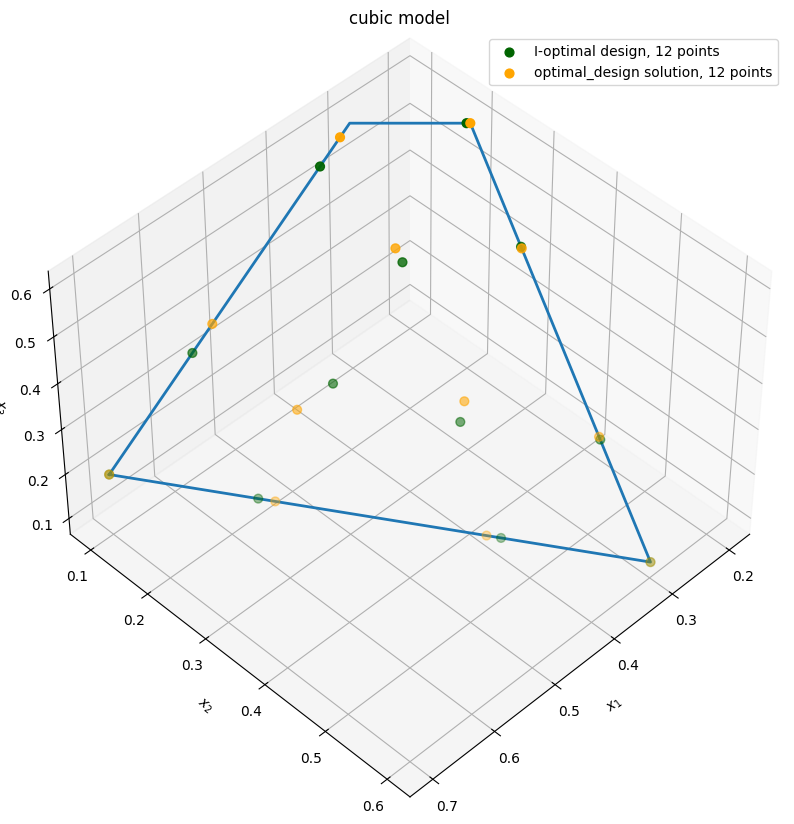

In [ ]:
data_model = DoEStrategy(
    domain=domain,
    criterion=IOptimalityCriterion(
        formula="x1 + x2 + x3 + {x1**2} + {x2**2} + {x3**2} + {x1**3} + {x2**3} + {x3**3} + x1:x2 + x1:x3 + x2:x3 + x1:x2:x3",
    ),
    ipopt_options={"disp": 0},
)
strategy = strategies.map(data_model=data_model)
i_optimal_design = strategy.ask(12)

i_opt = np.array(
    [
        [0.7000, 0.1000, 0.2000],
        [0.3000, 0.6000, 0.1000],
        [0.2031, 0.1969, 0.6000],
        [0.5899, 0.2376, 0.1725],
        [0.4105, 0.4619, 0.1276],
        [0.2720, 0.4882, 0.2398],
        [0.2281, 0.3124, 0.4595],
        [0.3492, 0.1000, 0.5508],
        [0.5614, 0.1000, 0.3386],
        [0.4621, 0.2342, 0.3037],
        [0.3353, 0.2228, 0.4419],
        [0.3782, 0.3618, 0.2600],
    ]
).T  # values taken from paper


fig = plt.figure(figsize=((10, 10)))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("cubic model")
ax.view_init(45, 45)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.rcParams["figure.figsize"] = (10, 8)

# plot feasible polytope
ax.plot(
    xs=[7 / 10, 3 / 10, 1 / 5, 3 / 10, 7 / 10],
    ys=[1 / 10, 3 / 5, 1 / 5, 1 / 10, 1 / 10],
    zs=[1 / 5, 1 / 10, 3 / 5, 3 / 5, 1 / 5],
    linewidth=2,
)

# plot I-optimal solution
ax.scatter(
    xs=i_opt[0],
    ys=i_opt[1],
    zs=i_opt[2],
    marker="o",
    s=40,
    color="darkgreen",
    label="I-optimal design, 12 points",
)

ax.scatter(
    xs=i_optimal_design[0],
    ys=i_optimal_design[1],
    zs=i_optimal_design[2],
    marker="o",
    s=40,
    color="orange",
    label="optimal_design solution, 12 points",
)

plt.legend()

## Nonlinear Constraints

Design generation also supports nonlinear constraints. The following 3 examples show what is possible.

First, a convenience function for plotting.

In [ ]:
def plot_results_3d(result, surface_func):
    u, v = np.mgrid[0 : 2 * np.pi : 100j, 0 : np.pi : 80j]
    X = np.cos(u) * np.sin(v)
    Y = np.sin(u) * np.sin(v)
    Z = surface_func(X, Y)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, alpha=0.3)
    ax.scatter(
        xs=result["x1"],
        ys=result["x2"],
        zs=result["x3"],
        marker="o",
        s=40,
        color="red",
    )
    ax.set(xlabel="x1", ylabel="x2", zlabel="x3")
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

### Example 1: Design inside a cone / nonlinear inequality

In the following example we have three design variables. 
We impose the constraint that all experiments have to be contained in the interior of a cone, which corresponds to the nonlinear inequality constraint
$\sqrt{x_1^2 + x_2^2} - x_3 \leq 0$.
The optimization is done for a linear model and we will see that it places the points on the surface of the cone so as to maximize the distance between them (although this is not explicitly the objective of the optimization).

In [ ]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds=(-1, 1)),
        ContinuousInput(key="x2", bounds=(-1, 1)),
        ContinuousInput(key="x3", bounds=(0, 1)),
    ],
    outputs=[ContinuousOutput(key="y")],
    constraints=[
        NonlinearInequalityConstraint(
            expression="(x1**2 + x2**2)**0.5 - x3",
            features=["x1", "x2", "x3"],
        ),
    ],
)

data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(formula="linear"),
    ipopt_options={"maxiter": 100, "disp": 0},
)
strategy = strategies.map(data_model=data_model)
result = strategy.ask(strategy.get_required_number_of_experiments())
result.round(3)
plot_results_3d(result, surface_func=lambda x1, x2: np.sqrt(x1**2 + x2**2))

We can do the same for a design space limited by an elliptical cone $x_1^2 + x_2^2 - x_3 \leq 0$.


In [ ]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds=(-1, 1)),
        ContinuousInput(key="x2", bounds=(-1, 1)),
        ContinuousInput(key="x3", bounds=(0, 1)),
    ],
    outputs=[ContinuousOutput(key="y")],
    constraints=[
        NonlinearInequalityConstraint(
            expression="x1**2 + x2**2 - x3",
            features=["x1", "x2", "x3"],
        ),
    ],
)
data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(formula="linear"),
    ipopt_options={"maxiter": 100, "disp": 0},
)
strategy = strategies.map(data_model=data_model)
result = strategy.ask(strategy.get_required_number_of_experiments())
result.round(3)
plot_results_3d(result, surface_func=lambda x1, x2: x1**2 + x2**2)

### Example 2: Design on the surface of a cone / nonlinear equality

We can also limit the design space to the surface of a cone, defined by the equality constraint $\sqrt{x_1^2 + x_2^2} - x_3 = 0$. Before, we observed that the experimental proposals happened to be on the surface of the cone, but now they are constrained so that this must be the case.

Remark: Due to missing sampling methods, the initial points provided to IPOPT don't satisfy the constraints. But this does not matter for the solution.


In [ ]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds=(-1, 1)),
        ContinuousInput(key="x2", bounds=(-1, 1)),
        ContinuousInput(key="x3", bounds=(0, 1)),
    ],
    outputs=[ContinuousOutput(key="y")],
    constraints=[
        NonlinearEqualityConstraint(
            expression="(x1**2 + x2**2)**0.5 - x3",
            features=["x1", "x2", "x3"],
        ),
    ],
)
data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(formula="linear"),
    ipopt_options={"maxiter": 100, "disp": 0},
)
strategy = strategies.map(data_model=data_model)
result = strategy.ask(12)
result.round(3)
plot_results_3d(result, surface_func=lambda x1, x2: np.sqrt(x1**2 + x2**2))

### Example 3: Batch constraints
Batch constraints can be used to create designs where each set of `multiplicity` subsequent experiments have the same value for a certain feature. This can be useful for setups where experiments are done in parallel and some parameters must be shared by experiments in the same parallel batch.

In the following example we fix the value of the decision variable `x1` for each batch of 3 experiments.   

In [ ]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds=(0, 1)),
        ContinuousInput(key="x2", bounds=(0, 1)),
        ContinuousInput(key="x3", bounds=(0, 1)),
    ],
    outputs=[ContinuousOutput(key="y")],
    constraints=[InterpointEqualityConstraint(feature="x1", multiplicity=3)],
)
data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(formula="linear"),
    ipopt_options={"maxiter": 100, "disp": 0},
)
strategy = strategies.map(data_model=data_model)
result = strategy.ask(12)
result.round(3)